In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2023-04-22 22:02:40.141423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img,features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d*2,4,2,1),
            self.block(features_d*2, features_d*4,4,2,1),
            self.block(features_d*4, features_d*8,4,2,1),
            nn.Conv2d(features_d*8,1, kernel_size=4,stride=2,padding=0), #single value output determining if the photo is real
            nn.Sigmoid()
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)
            

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self.block(z_dim, features_g*16, 4, 1, 0),
            self.block(features_g*16, features_g*8, 4, 2, 1), # 8x8
            self.block(features_g*8, features_g*4, 4, 2, 1), #16x16
            self.block(features_g*4, features_g*2, 4, 2, 1), #32x32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4,stride=2, padding=1,
            ),
            nn.Tanh(),
        )
        
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.gen(x)

In [4]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
                
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    init_weights(disc)
    assert disc(x).shape == (N, 1,1,1)
    gen = Generator(z_dim, in_channels, 8)
    z = torch.randn((N, z_dim, 1,1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

In [5]:
test()

Success


# Training the model

In [12]:
#hyperparameters
lr = .0002
batch_size = 128
image_size = 64
channels_img = 3
z_dim = 128
n_epochs = 25

# these two need to be the same to match the paper
features_disc = 64
features_gen = 64

In [13]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),
    ]
)

# dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)
# dataset = datasets.ImageFolder(root="CIFAR10", transform=transforms)
dataset = datasets.CIFAR10(root="dataset/", train=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle=True)
gen = Generator(z_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)
init_weights(gen)
init_weights(disc)

optim_g = optim.Adam(gen.parameters(), lr=lr, betas=(0.5,0.999))
optim_d = optim.Adam(disc.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCELoss()

gen.train()
disc.train()

for epoch in range(n_epochs):
    for step, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn((batch_size, z_dim, 1,1)).to(device)
        fake = gen(noise)
        
        # train discriminator
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        optim_d.step()
        
        # train generator
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optim_g.step()
    print(f"epoch {epoch+1}: completed")

epoch 1: completed
epoch 2: completed
epoch 3: completed
epoch 4: completed
epoch 5: completed
epoch 6: completed
epoch 7: completed
epoch 8: completed
epoch 9: completed
epoch 10: completed
epoch 11: completed
epoch 12: completed
epoch 13: completed
epoch 14: completed
epoch 15: completed
epoch 16: completed
epoch 17: completed
epoch 18: completed
epoch 19: completed
epoch 20: completed
epoch 21: completed
epoch 22: completed
epoch 23: completed
epoch 24: completed
epoch 25: completed


In [23]:
torch.save(gen, "gen.pth")
torch.save(disc, "disc.pth")

In [24]:
gen = torch.load("gen.pth")
disc = torch.load("disc.pth")

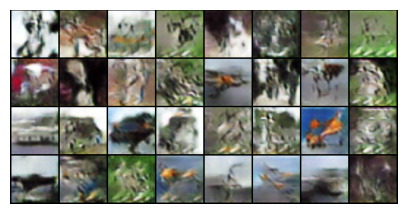

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Generate random noise vectors
noise = torch.randn(32, 128, 1, 1, device=device)

# Generate fake images
fake_images = gen(noise)

# Rescale pixel values to be between 0 and 1
fake_images = (fake_images + 1) / 2.0

# Create a grid of the generated images and display them
fig = plt.figure(figsize=(5, 5))
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True),
        (1, 2, 0),
    )
)
plt.savefig('./gan_group_img.jpg')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

for i in range(10):
    condition = torch.tensor([i] * 1, device=device)

    # Generate random noise vectors
    noise = torch.randn(1, 128, 1, 1, device=device)

    # Generate fake images
    fake_images = gen(noise,condition)

    # Rescale pixel values to be between 0 and 1
    fake_images = (fake_images + 1) / 2.0
    print(fake_images.shape)

    # Create a grid of the generated images and display them
    fig = plt.figure(figsize=(5, 5))
    plt.axis("off")
    
    image = np.transpose(vutils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True), (1, 2, 0),)
    plt.imshow(image)
    # plt.savefig(f'./gan_img_{i}.jpg')
    plt.show()